In [1]:
# INSTALACIONES REQUERIDAS:
#%pip install antlr4-python3-runtime
#%pip install seaborn

In [2]:
# Todos los imports
import os
import numpy as np
import pandas as pd
from antlr4 import *
import seaborn as sns
from JavaLexer import JavaLexer
import matplotlib.pyplot as plt
from JavaParser import JavaParser
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score, classification_report



In [3]:
# ConPlag dataset import
def loadConPlag(train_path, test_path, labels_path):
    # Cargar los pares de entrenamiento y prueba
    train_pairs = pd.read_csv(train_path, header=None, names=['pair'])
    test_pairs = pd.read_csv(test_path, header=None, names=['pair'])

    # Cargar las etiquetas
    labels = pd.read_csv(labels_path)
    labels['pair'] = labels['sub1'] + '_' + labels['sub2']

    # Unir las etiquetas con los pares de entrenamiento y prueba
    train_pairs = train_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')
    test_pairs = test_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')

    print(f"Total de codigos cargados: {len(train_pairs) + len(test_pairs)}")

    return train_pairs, test_pairs

# Cargar los datos
train_pairs, test_pairs = loadConPlag(
    '../datasets/ConPlag/versions/train_pairs.csv',
    '../datasets/ConPlag/versions/test_pairs.csv',
    '../datasets/ConPlag/versions/labels.csv'
)

# contar cuantos plagios y no plagios hay en total
total_plagios = train_pairs['verdict'].value_counts().get('plagio', 0)
total_no_plagios = train_pairs['verdict'].value_counts().get('no_plagio', 0)


# Mostrar el formato del dataset
print("Formato del dataset:")
print(train_pairs.head())


# Función para cargar el código de los pares
def load_code(submission_id):
    folder_name = submission_id
    code1_id, code2_id = folder_name.split('_')

    # Rutas de los archivos de código
    code1_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code1_id}.java'
    code2_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code2_id}.java'

    # Leer el contenido de los archivos
    with open(code1_path, 'r', encoding='utf-8') as file:
        code1 = file.read()
    with open(code2_path, 'r', encoding='utf-8') as file:
        code2 = file.read()

    

    return code1, code2

# Cargar los códigos correspondientes a todos los pares de entrenamiento y prueba en un solo dataset
def load_all_codes(train, test):
    all_codes = []
    for index, row in pd.concat([train, test]).iterrows():
        code1, code2 = load_code(row['pair'])
        all_codes.append({'code1': code1, 'code2': code2, 'verdict': row['verdict']})
    
    return pd.DataFrame(all_codes)

conPlagCodes = load_all_codes(train_pairs, test_pairs)
print (f"Total de códigos cargados en variable: {len(conPlagCodes)}")


Total de codigos cargados: 911
Formato del dataset:
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0
Total de códigos cargados en variable: 911


In [4]:
# Ir-Plag import
def load_IRPlag_dataset(root_path):
    all_pairs = []


    for case_name in os.listdir(root_path):
        case_path = os.path.join(root_path, case_name)
        if not os.path.isdir(case_path):
            continue

        # Leer originales
        original_dir = os.path.join(case_path, 'original')
        original_codes = []
        for file in os.listdir(original_dir):
            if file.endswith('.java'):
                with open(os.path.join(original_dir, file), 'r', encoding='utf-8') as f:
                    original_codes.append(f.read())

        # Leer plagios en subdirectorios recursivos
        plag_dir = os.path.join(case_path, 'plagiarized')
        for dirpath, _, files in os.walk(plag_dir):
            for file in files:
                if file.endswith('.java'):
                    with open(os.path.join(dirpath, file), 'r', encoding='utf-8') as f:
                        plag_code = f.read()
                    for orig_code in original_codes:
                        all_pairs.append({
                            'code1': orig_code,
                            'code2': plag_code,
                            'verdict': 1
                        })

        # Leer no-plagios en subdirectorios recursivos
        nonplag_dir = os.path.join(case_path, 'non-plagiarized')
        for dirpath, _, files in os.walk(nonplag_dir):
            for file in files:
                if file.endswith('.java'):
                    with open(os.path.join(dirpath, file), 'r', encoding='utf-8') as f:
                        nonplag_code = f.read()
                    for orig_code in original_codes:
                        all_pairs.append({
                            'code1': orig_code,
                            'code2': nonplag_code,
                            'verdict': 0
                        })


    print(f"Total de pares generados: {len(all_pairs)}")
    return pd.DataFrame(all_pairs)

irPlagCodes = load_IRPlag_dataset("../datasets/IR-Plag")
print (f"Total de códigos cargados en variable: {len(irPlagCodes)}")
print(irPlagCodes)


Total de pares generados: 460
Total de códigos cargados en variable: 460
                                                 code1  \
0    \npublic class T1 {\n\tpublic static void main...   
1    \npublic class T1 {\n\tpublic static void main...   
2    \npublic class T1 {\n\tpublic static void main...   
3    \npublic class T1 {\n\tpublic static void main...   
4    \npublic class T1 {\n\tpublic static void main...   
..                                                 ...   
455  import java.util.Scanner;\n\npublic class T7 {...   
456  import java.util.Scanner;\n\npublic class T7 {...   
457  import java.util.Scanner;\n\npublic class T7 {...   
458  import java.util.Scanner;\n\npublic class T7 {...   
459  import java.util.Scanner;\n\npublic class T7 {...   

                                                 code2  verdict  
0    /*\n * To change this license header, choose L...        1  
1    public class Main {\n\n    public static void ...        1  
2    \n\n\n\n/*\n * To change th

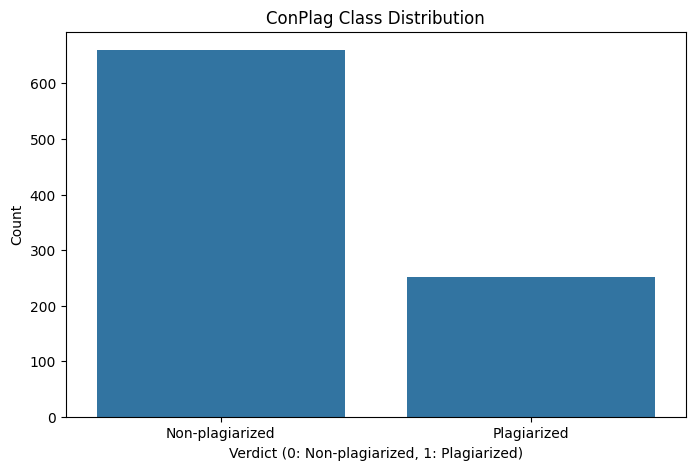

Total Plagiarized: 251 | Total Non-plagiarized: 660


In [5]:
def plot_conplag_distribution(df, title):
    total = train_pairs['verdict'].value_counts() + test_pairs['verdict'].value_counts()
    total = total.reindex([0, 1], fill_value=0)  # Asegurar que ambos valores estén presentes
    plt.figure(figsize=(8, 5))
    sns.barplot(x=total.index, y=total.values)
    plt.title(title)
    plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
    plt.show()
    print(f"Total Plagiarized: {total.get(1, 0)} | Total Non-plagiarized: {total.get(0, 0)}")
 

plot_conplag_distribution(conPlagCodes, 'ConPlag Class Distribution')


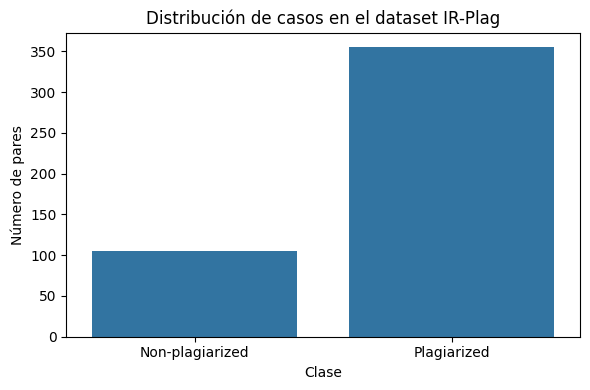

Total Plagiarized: 355 | Total Non-plagiarized: 105


In [6]:

def plot_distribution(df):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='verdict')
    plt.title('Distribución de casos en el dataset IR-Plag')
    plt.xlabel('Clase')
    plt.ylabel('Número de pares')
    plt.xticks([1, 0], ['Plagiarized', 'Non-plagiarized'])
    plt.tight_layout()
    plt.show()
    counts = df['verdict'].value_counts()
    total_plag = counts.get(1, 0)
    total_non_plag = counts.get(0, 0)
    print(f"Total Plagiarized: {total_plag} | Total Non-plagiarized: {total_non_plag}")


plot_distribution(irPlagCodes)

longitud de ambos dfs 1371
longitud del df 1371


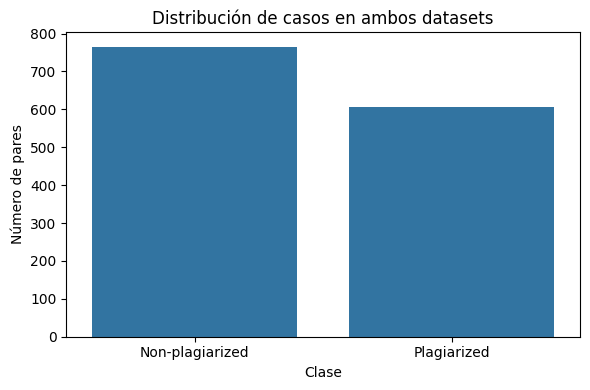

Total Plagiarized: 606 | Total Non-plagiarized: 765


In [ ]:
print(f'longitud de ambos dfs {len(irPlagCodes) + len(conPlagCodes)}')
df_combined = pd.concat([irPlagCodes, conPlagCodes], ignore_index=True)
print(f'longitud del df {len(df_combined)}')
plt.figure(figsize=(6, 4))
sns.countplot(data=df_combined, x='verdict')
plt.title('Distribución de casos en ambos datasets')
plt.xlabel('Clase')
plt.ylabel('Número de pares')
plt.xticks([1, 0], ['Plagio', 'No Plagio'])
plt.tight_layout()
plt.show()
counts = df_combined['verdict'].value_counts()
total_plag = counts.get(1, 0)
total_non_plag = counts.get(0, 0)
print(f"Total Plagiarized: {total_plag} | Total Non-plagiarized: {total_non_plag}")



# Ahora cambiemos el nombre de variables para que todo use el dataset combinado
conPlagCodes = df_combined

In [8]:
# Configuración del Tokenizador
CRITICAL_TOKENS = {
    # Identificadores (conservamos tipo pero normalizamos nombres)
    'IDENTIFIER': lambda t: f'VAR_{t.text[0]}_{len(t.text)}',  
    
    # Literales
    'DECIMAL_LITERAL': lambda t: 'LIT_NUM',
    'STRING_LITERAL': lambda t: 'LIT_STR',
    
    # Operadores
    'EQUAL': lambda t: 'OP_=',
    'NOTEQUAL': lambda t: 'OP_!=',
    'LT': lambda t: 'OP_<',
    'GT': lambda t: 'OP_>',
    'ADD': lambda t: 'OP_+',
    'SUB': lambda t: 'OP_-',
    
    # Estructuras de control
    'IF': lambda t: 'CTRL_if',
    'FOR': lambda t: 'CTRL_for',
    'WHILE': lambda t: 'CTRL_while'
}

# Tokens a ignorar
IGNORE_TOKENS = {
    ';', '(', ')', '[', ']', '{', '}', '@', ',', '.', ':'
}

def tokenize_java(code):
    input_stream = InputStream(code)
    lexer = JavaLexer(input_stream)
    stream = CommonTokenStream(lexer)
    stream.fill()
    
    # Se genera un array en el que se almacenarán los tokens
    tokens = []
    for token in stream.tokens:
        if token.channel != Lexer.DEFAULT_TOKEN_CHANNEL:
            continue
            
        # Obtenemos el nombre del token y su texto
        token_name = lexer.symbolicNames[token.type]
        token_text = token.text.strip()

        # Ignoramos tokens que no son relevantes (definidos por nosotros)
        if token_text in IGNORE_TOKENS:
            continue
        
        # Procesamos tokens críticos
        if token_name in CRITICAL_TOKENS:
            processed = CRITICAL_TOKENS[token_name](token)
            tokens.append(processed)
        else:
            # Conservamos otros tokens relevantes
            if len(token_text) > 1: 
                tokens.append(token_text)
    
    return tokens


In [9]:
# TF-IDF function
def compute_tfidf_similarity(code1, code2):
    # Tokenizar y preprocesar los códigos
    tokens1 = tokenize_java(code1)
    tokens2 = tokenize_java(code2)

    # Vectorizar los códigos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([' '.join(tokens1), ' '.join(tokens2)])

    # Calcular la similitud coseno
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    
    return similarity[0][0] 



conplag = compute_tfidf_similarity(conPlagCodes['code1'][0], conPlagCodes['code2'][0])

print(f"mixed datasets TF-IDF Similarity: {conplag:.4f}")

mixed datasets TF-IDF Similarity: 0.9841


In [10]:

# Función para calcular similitudes para todos los pares
def calculate_all_similarities(pairs_df):
    similarities = []
    for idx, row in pairs_df.iterrows():
        try:
            sim = compute_tfidf_similarity(row['code1'], row['code2'])
            similarities.append(sim)
        except Exception as e:
            print(f"Error procesando par {row['pair']}: {str(e)}")
            similarities.append(0)
    return np.array(similarities)


# Misma funcion pero para clasificar en niveles
def calculate_all_similarities_multi(pairs_df):
    similarities = []
    levels = []

    # En base a lo mencionado por libraryacademy, clasificamos los niveles de plagio
    def clasificar_nivel(similitud):
        if similitud <= 0.10:
            return 0  # Nivel 0: Sin plagio
        elif similitud <= 0.40:
            return 1  # Nivel 1: Plagio leve
        elif similitud <= 0.60:
            return 2  # Nivel 2: Plagio moderado
        else:
            return 3  # Nivel 3: Plagio severo

    
    for idx, row in pairs_df.iterrows():
        try:
            sim = compute_tfidf_similarity(row['code1'], row['code2'])
            similarities.append(sim)
            levels.append(clasificar_nivel(sim))
        except Exception as e:
            print(f"Error procesando par {row['pair']}: {str(e)}")
            similarities.append(0)
            levels.append(0)  # Asumimos sin plagio si falla
     
    # Añadir columnas nuevas al dataframe original
    pairs_df['similarity'] = similarities
    pairs_df['plagiarism_level'] = levels
    
    return pairs_df


In [11]:
conPlagCodesMul = calculate_all_similarities_multi(conPlagCodes)
conPlagCodesBi = conPlagCodes.copy()
conPlagCodesBi['similarity'] = calculate_all_similarities(conPlagCodesBi)


Threshold óptimo: 0.72, F1-score: 0.62


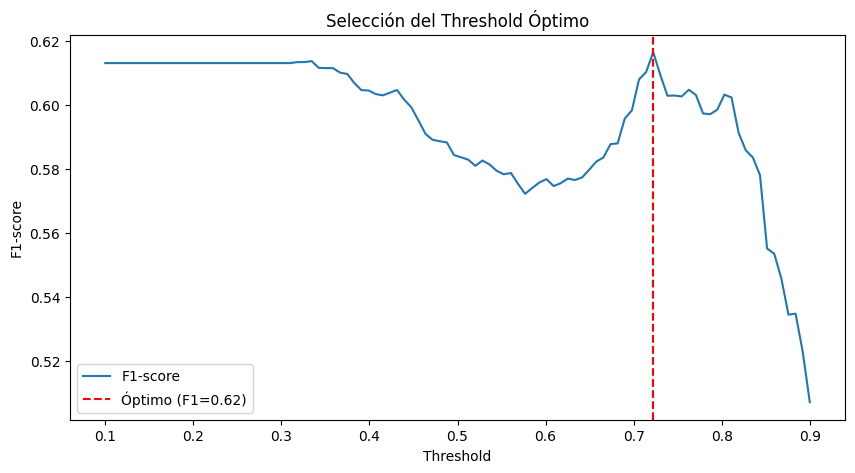

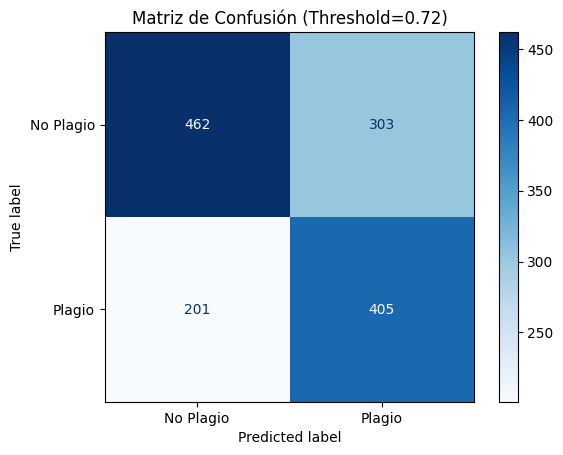

No Plagio: 663, Plagio: 708
accuracy: 0.63
precision: 0.57
recall: 0.67
f1-score: 0.62


In [12]:
def clasif_binario(conPlagCodes):
    # Calcular similitudes para ConPlag
    
    
    # Preparar etiquetas verdaderas (y_true)
    y_true = conPlagCodesBi['verdict'].values

    # Calcular threshold óptimo
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = [f1_score(y_true, conPlagCodesBi['similarity'] > t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)] # + 0.027 # Ajuste manual, sirve para probar otros thresholds
    best_f1 = max(f1_scores)

    print(f"Threshold óptimo: {best_threshold:.2f}, F1-score: {best_f1:.2f}")

    # Visualización
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, f1_scores, label='F1-score')
    plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo (F1={best_f1:.2f})')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.title('Selección del Threshold Óptimo')
    plt.legend()
    plt.show()

    # Matriz de confusión con el threshold óptimo
    y_pred = (conPlagCodesBi['similarity'] > best_threshold).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['No Plagio', 'Plagio'], 
                                            cmap=plt.cm.Blues) 
    plt.title(f'Matriz de Confusión (Threshold={best_threshold:.2f})')
    plt.show()

    print(f'No Plagio: {np.sum(y_pred == 0)}, Plagio: {np.sum(y_pred == 1)}')

    # Reporte de clasificación

    print(f'accuracy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'precision: {precision_score(y_true, y_pred):.2f}')
    print(f'recall: {recall_score(y_true, y_pred):.2f}')
    print(f'f1-score: {f1_score(y_true, y_pred):.2f}')

clasif_binario(conPlagCodesBi)

plagiarism_level
3    1082
2     264
1      25
Name: count, dtype: int64


C:\Users\patom\AppData\Local\Temp\ipykernel_32668\3837380316.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


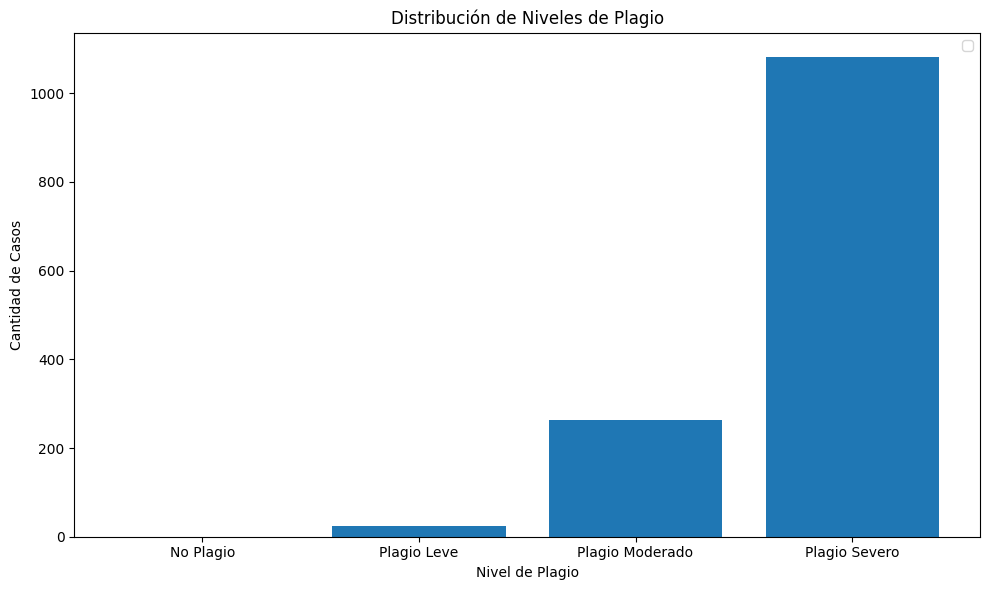

In [13]:
def clasif_multi(conPlagCodes):
    # Calcular similitudes y niveles de plagio
    print(conPlagCodes['plagiarism_level'].value_counts())


    # Etiquetas verdaderas y predichas
    y_true = conPlagCodesMul['verdict'].values
    y_pred = conPlagCodesMul['plagiarism_level'].values

    # Contar frecuencia por clase
    true_counts = np.bincount(y_true)
    pred_counts = np.bincount(y_pred)

    # Gráfica de barras
    labels = ['No Plagio', 'Plagio Leve', 'Plagio Moderado', 'Plagio Severo']
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 6))
    plt.bar(x, pred_counts)
    plt.xlabel('Nivel de Plagio')
    plt.ylabel('Cantidad de Casos')
    plt.title('Distribución de Niveles de Plagio')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


clasif_multi(conPlagCodesMul)